Unconditional GAN to generate MNIST handwritten digits

1. imports

In [21]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.layers import Dense, Flatten, Reshape,LeakyReLU,Embedding,Input
from keras.models import Sequential
from keras.optimizers import Adam

2. Initialize MNIST image shape and dimension

In [3]:
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels)

z_dim = 100

3. functions for building generator, discrimantor and gan or adversarial(a sequence of generator and dicriminator)

In [5]:
def build_generator(img_shape, z_dim):
    model = Sequential()

    model.add(Dense(128, input_dim=z_dim))

    model.add(LeakyReLU(alpha=0.01))

    model.add(Dense(28 * 28 * 1, activation='tanh'))

    model.add(Reshape(img_shape))

    return model

In [6]:
def build_discriminator(img_shape):

    model = Sequential()

    model.add(Flatten(input_shape=img_shape))

    model.add(Dense(128))

    model.add(LeakyReLU(alpha=0.01))

    model.add(Dense(1, activation='sigmoid'))

    return model

In [7]:
def build_gan(generator, discriminator):

    model = Sequential()

    model.add(generator)
    model.add(discriminator)

    return model

4. Building the stacked model so that we can train the generator with discriminator loss. 

In [8]:
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

#no compile for generator as we train the gan below and not generator individually
generator = build_generator(img_shape, z_dim)

discriminator.trainable = False

gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

5. Training loop

In [12]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):

    (X_train, _), (_, _) = mnist.load_data()

    # Normalize the images to [-1, 1]. we subtract the pixel values by 127.5 which is 255/2 so that the maximum values on both sides become (-127.5,+127.5) and now it becomes easy to normalize it into[-1,1]
    X_train = (X_train - 127.5)/ 127.5
    # expand to 3d, e.g. add channels dimension
    #images are 2D arrays of pixels and convolutional neural networks expect 3D arrays of images as input, where each image has one or more channels.
    X_train = np.expand_dims(X_train, axis=3)
    
    #real labels for the batch
    real = np.ones((batch_size, 1))

    #fake labels for the batch
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        #select real images for the batch
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_imgs = X_train[idx]

        # generate noise images for the batch and passing it to generator to create them
        noise = np.random.normal(0, 1, (batch_size, 100))
        fake_imgs = generator.predict(noise)

        #train the discriminator (real labels are 1 and fake are 0 )
        #the train on batch method does one round of forward and backpropagation
        d_loss_real = discriminator.train_on_batch(real_imgs, real)
        d_loss_fake = discriminator.train_on_batch(fake_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        #train the generator to have the discriminator label noise samples as real
        #This updates the weights of the generator to move them toward getting the discriminator to predict “these are real images” for fake/generated images: this trains the generator to fool the discriminator.
        noise = np.random.normal(0, 1, (batch_size, 100))
        g_loss = gan.train_on_batch(noise, real)

        if (iteration + 1) % sample_interval == 0:

            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            sample_images(iteration,generator)

In [15]:
def sample_images(iteration, generator, image_grid_rows=4, image_grid_columns=4):

    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    gen_imgs = generator.predict(z)

    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            #fig.savefig("images/%d.png" % iteration)
            cnt += 1

4/4 [==============================] - 0s 2ms/step
100 [D loss: 0.253086, acc.: 90.23%] [G loss: 3.977027]
4/4 [==============================] - 0s 3ms/step
200 [D loss: 0.313139, acc.: 85.16%] [G loss: 3.475202]
4/4 [==============================] - 0s 3ms/step
300 [D loss: 0.488479, acc.: 82.81%] [G loss: 3.690549]
4/4 [==============================] - 0s 3ms/step
400 [D loss: 0.481511, acc.: 76.95%] [G loss: 3.079522]
4/4 [==============================] - 0s 3ms/step
500 [D loss: 0.475469, acc.: 80.08%] [G loss: 2.849972]
4/4 [==============================] - 0s 4ms/step
600 [D loss: 0.387846, acc.: 82.42%] [G loss: 2.827375]
4/4 [==============================] - 0s 3ms/step
700 [D loss: 0.501192, acc.: 79.69%] [G loss: 3.123435]
4/4 [==============================] - 0s 4ms/step
800 [D loss: 0.316273, acc.: 85.94%] [G loss: 3.422214]
4/4 [==============================] - 0s 4ms/step
900 [D loss: 0.261212, acc.: 89.45%] [G loss: 3.327271]
4/4 [==============================] 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


Streaming output truncated to the last 5000 lines.
4/4 [==============================] - 0s 3ms/step
5200 [D loss: 0.449188, acc.: 82.03%] [G loss: 2.834628]
4/4 [==============================] - 0s 3ms/step
5300 [D loss: 0.388375, acc.: 82.42%] [G loss: 2.708875]
4/4 [==============================] - 0s 6ms/step
5400 [D loss: 0.490382, acc.: 79.69%] [G loss: 3.046449]
4/4 [==============================] - 0s 6ms/step
5500 [D loss: 0.358257, acc.: 85.55%] [G loss: 2.898453]
4/4 [==============================] - 0s 6ms/step
5600 [D loss: 0.297996, acc.: 89.06%] [G loss: 2.939224]
4/4 [==============================] - 0s 3ms/step
5700 [D loss: 0.430708, acc.: 81.25%] [G loss: 2.429883]
4/4 [==============================] - 0s 4ms/step
5800 [D loss: 0.370175, acc.: 84.38%] [G loss: 2.586298]
4/4 [==============================] - 0s 3ms/step
5900 [D loss: 0.389133, acc.: 81.25%] [G loss: 2.799169]
4/4 [==============================] - 0s 5ms/step
6000 [D loss: 0.379219, acc.: 83.2

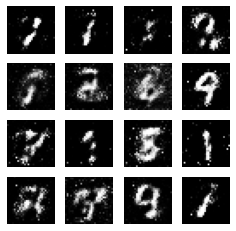

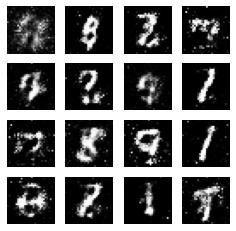

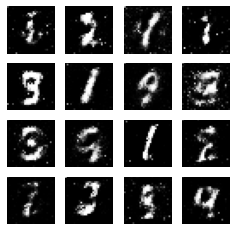

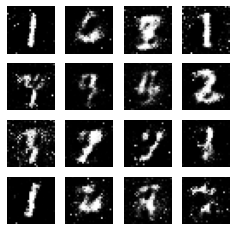

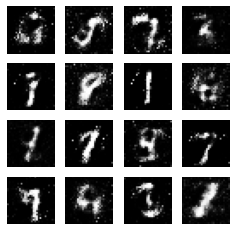

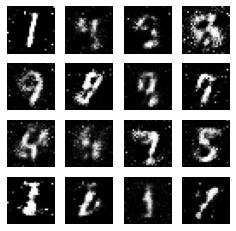

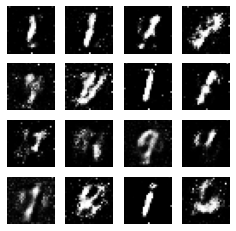

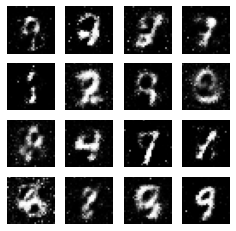

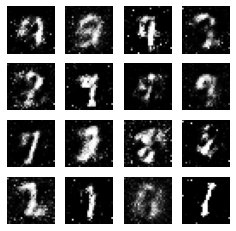

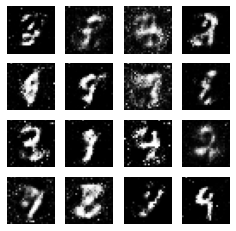

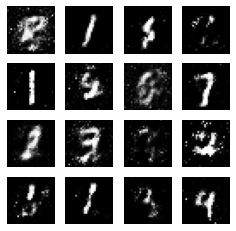

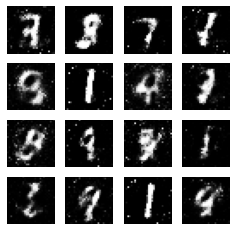

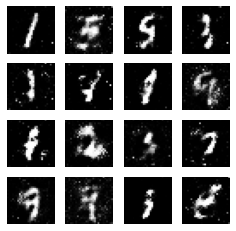

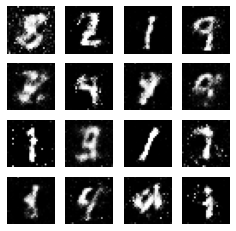

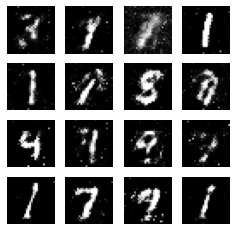

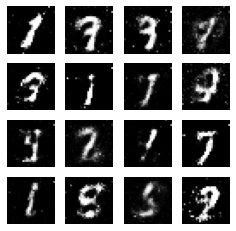

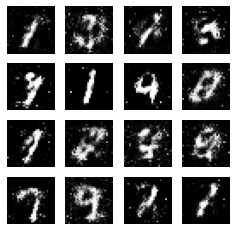

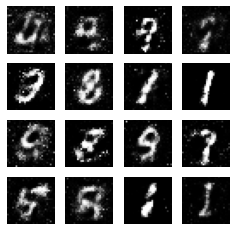

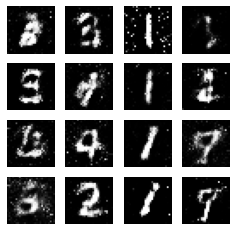

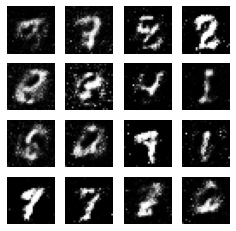

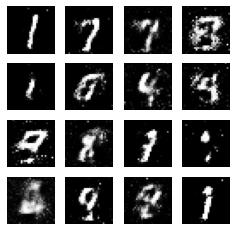

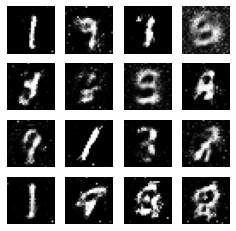

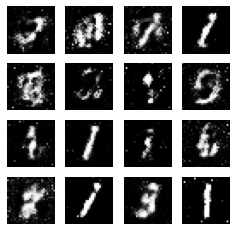

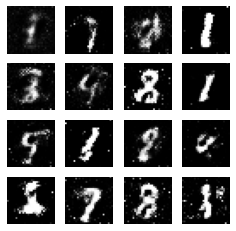

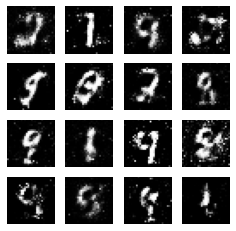

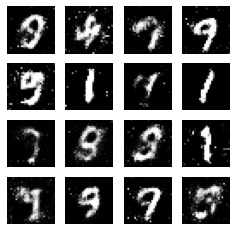

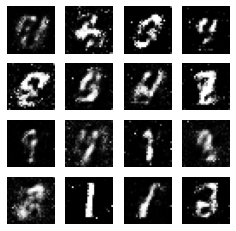

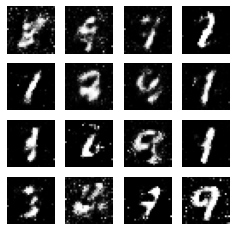

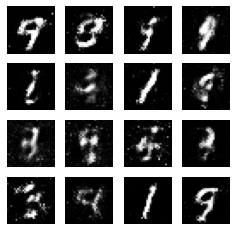

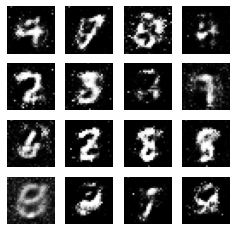

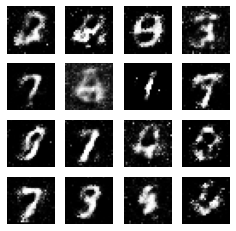

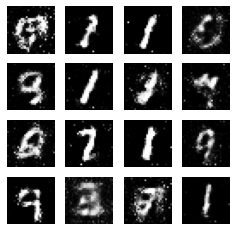

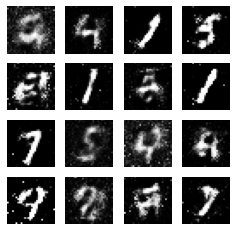

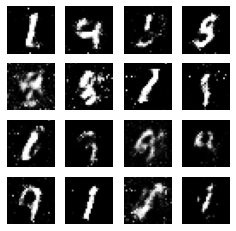

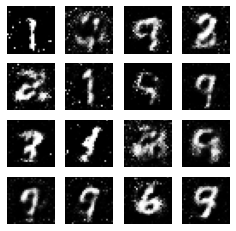

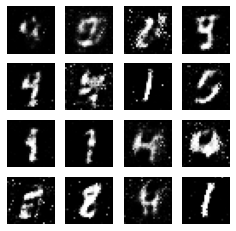

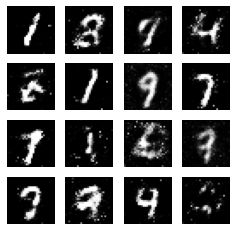

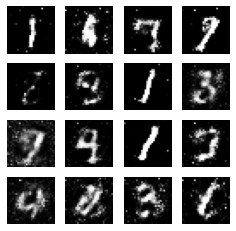

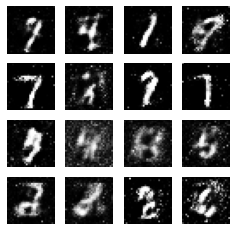

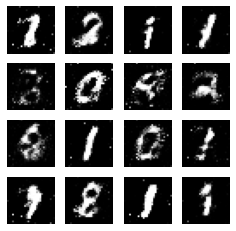

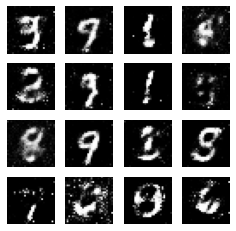

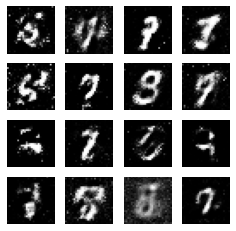

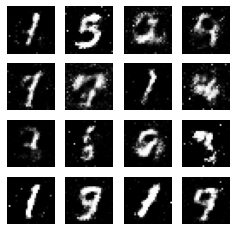

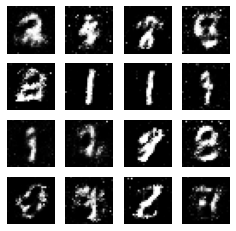

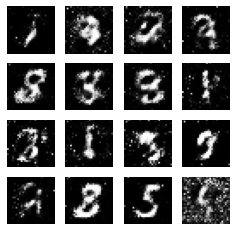

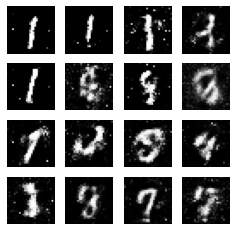

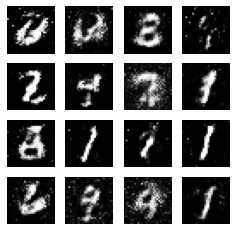

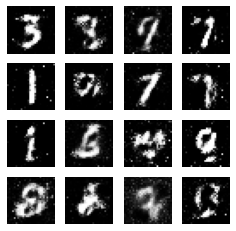

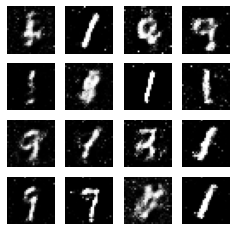

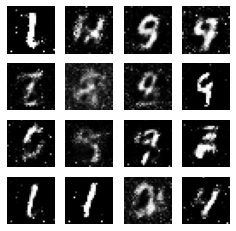

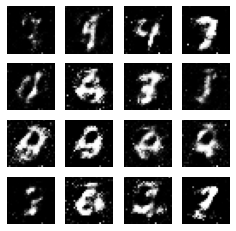

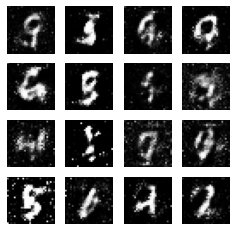

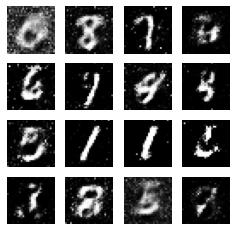

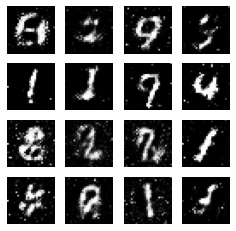

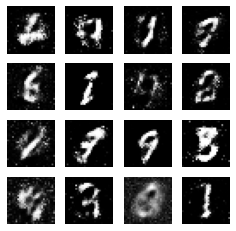

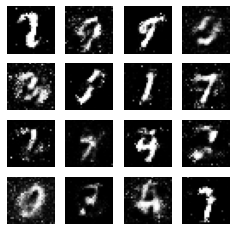

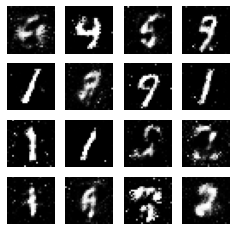

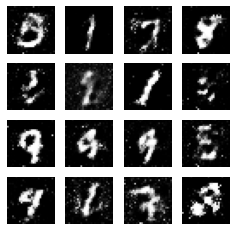

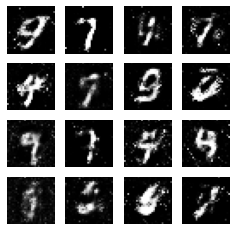

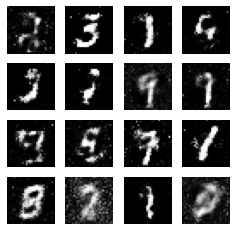

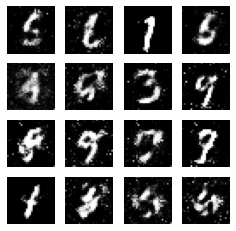

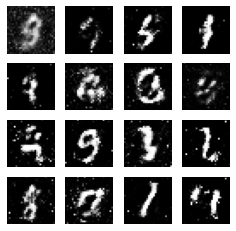

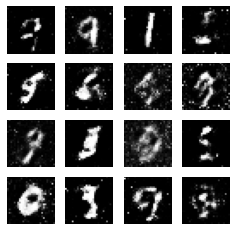

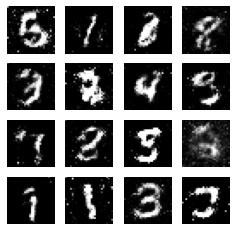

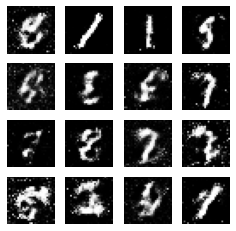

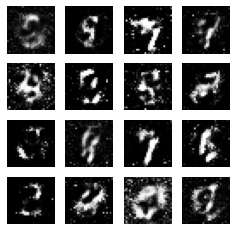

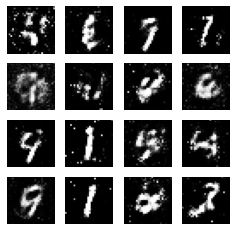

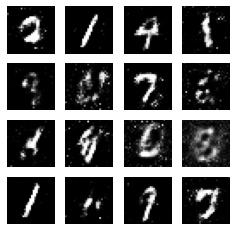

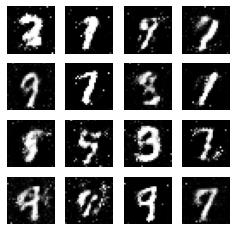

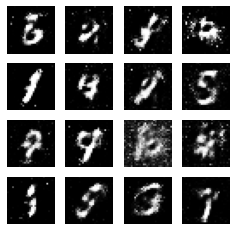

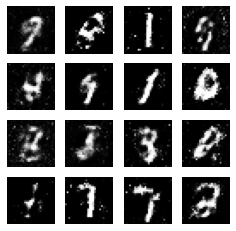

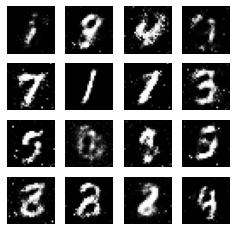

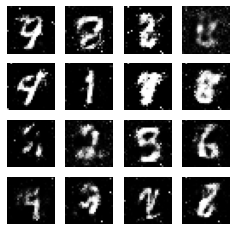

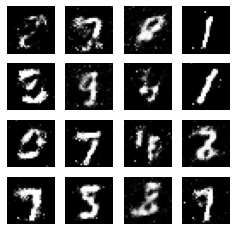

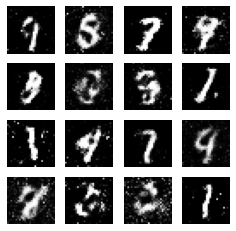

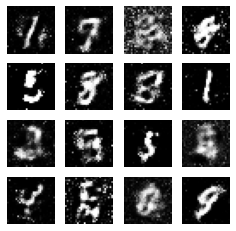

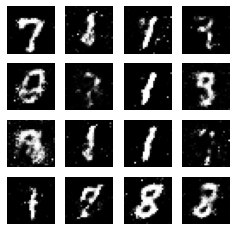

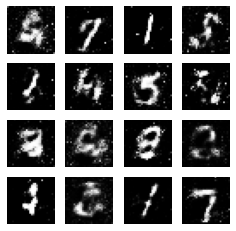

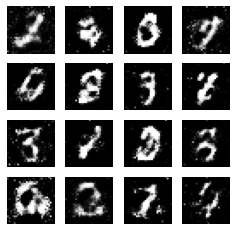

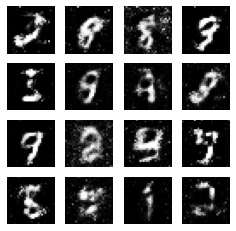

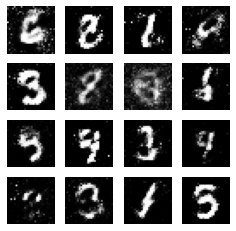

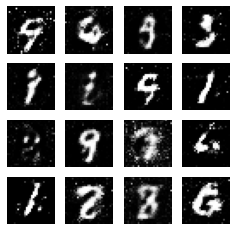

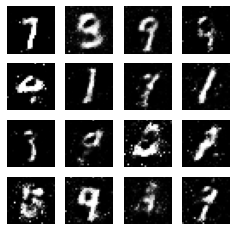

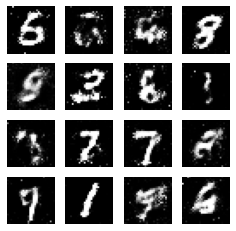

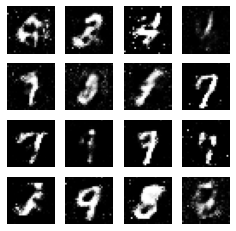

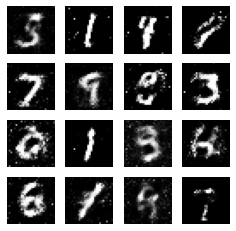

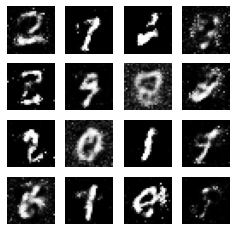

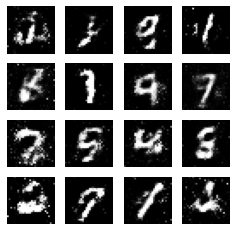

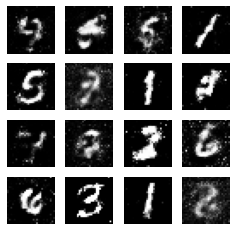

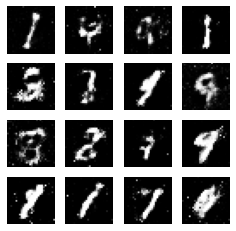

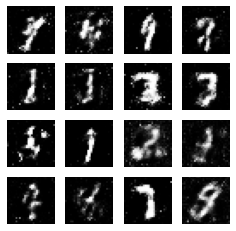

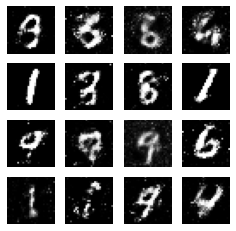

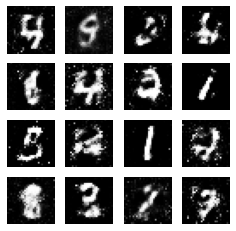

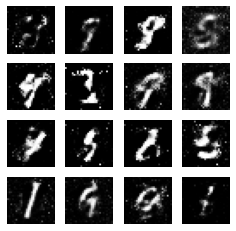

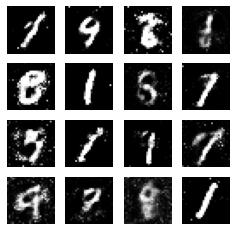

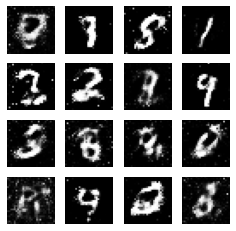

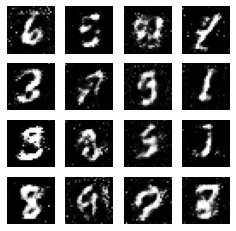

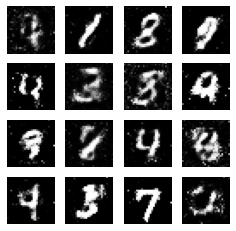

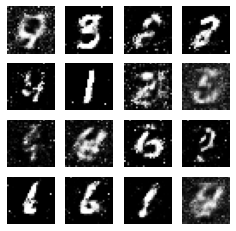

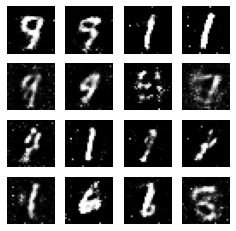

In [18]:
iterations = 10000
batch_size = 128
sample_interval = 100

train(iterations, batch_size, sample_interval)